In [35]:
from sklearn.model_selection import train_test_split
import numpy as np
from numpy import loadtxt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import curve_fit
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [36]:
data = np.loadtxt('conf.txt').reshape(-1, 8, 8)
Temp = np.loadtxt('invBeta.txt')
beta = 1 / Temp  # beta
N = 100          # category number
range = 1./(N-2) # interval range
# hot_one representation of size (beta samples x total category)
beta_hot = np.empty((len(beta), N)) 
for count, beta_n in enumerate(beta):
    countt = 0
    hot_one = np.zeros(N)
    for inf in np.arange(0, 0.99, range): #por ser ranchero, para que no sobrepase el intervalo de 1.
        if beta_n < 0:
            hot_one[0] = 1
        elif inf <= beta_n < (inf + range):
            hot_one[countt + 1] = 1 #there's a previous category of neg values
        elif beta_n >= 1:
            hot_one[N-1] = 1
        countt+=1
    beta_hot[count] = hot_one

data, beta_hot = data[1837:].astype(int), beta_hot[1837:].astype(int)
print('data shape:{}, and categorical beta:{}, beta:{}'.format(data.shape, beta_hot.shape, beta.shape))


data shape:(8163, 8, 8), and categorical beta:(8163, 100), beta:(10000,)


In [37]:
a = -1
print(beta[a],beta_hot[a])

0.20001960192098825 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [38]:
# We cut out unnecesary samples
X_train_null, X_test, y_train_null, y_test = train_test_split(data, beta_hot, test_size=0.2)
# We train with the whole dataset
X_train, y_train = data, beta_hot
print('training with the whole dataset: {}'.format(y_train.shape))

#es = EarlyStopping(monitor = 'loss', min_delta = 0.01, patience = 250, verbose = 1)
model_cp = ModelCheckpoint(filepath = 'best_model{epoch}.h5', monitor = 'loss', save_best_only = True, verbose = 1, save_freq=100)

model = models.Sequential()
# one filter of 3x3
model.add(layers.Conv2D(1, (3, 3), (2,2), padding='same', activation='relu', input_shape=(8, 8, 1)))
model.add(layers.Flatten())
#model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(100, activation='softmax'))
model.summary()
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=5000, 
                    validation_data=(X_test, y_test), verbose = 1, callbacks = [model_cp])

training with the whole dataset: (8163, 100)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 4, 4, 1)           10        
                                                                 
 flatten_4 (Flatten)         (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 100)               1700      
                                                                 
Total params: 1,710
Trainable params: 1,710
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5000
256/256 [==============================] - ETA: 0s - loss: 4.2833 - accuracy: 0.0282
Epoch 1: loss improved from inf to 4.28333, saving model to best_model.h5
256/256 [==============================] - 2s 7ms/step - loss: 4.2833 - accuracy: 0.0282 - val_loss

KeyboardInterrupt: 

(3, 3, 1, 1)


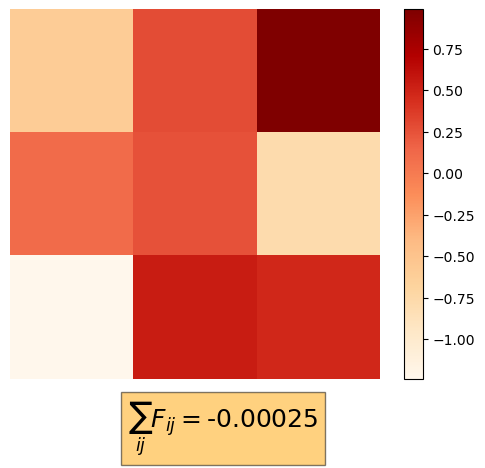

In [ ]:
filters, biases = model.layers[0].get_weights()
print(filters.shape)
file = open('filters.txt', 'w')
for row in filters[:,:,0,0]:
  np.savetxt(file, row)
file.close()
fig, ax = plt.subplots(1, 1)
im = ax.imshow(filters[:,:,0,0], cmap=mpl.colormaps['OrRd'])
ax.axis('off')
plt.colorbar(im, ax=ax)
plt.figtext(0.5, 0.01, "$\sum_{ij}F_{ij}=$"+"{:.5f}".format(np.sum(filters[:,:,0,0])), ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
plt.show()

(16, 100)


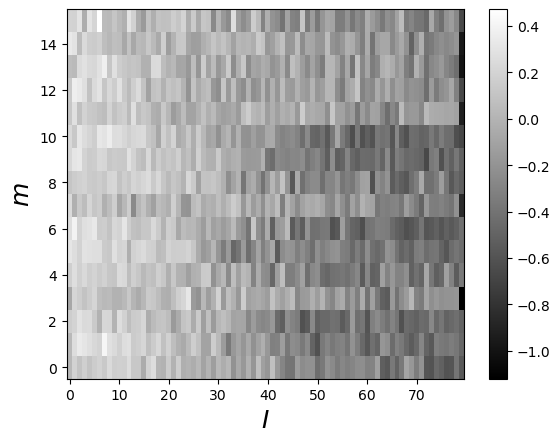

In [ ]:
filters_m, biases_m = model.layers[2].get_weights()
print(filters_m.shape)
file = open('weights.txt', 'w')
for row in filters_m[:,:]:
  np.savetxt(file, row)
file.close()
fig, ax = plt.subplots(1, 1)
im = ax.imshow(filters_m[:,20:], cmap=mpl.colormaps['gray'], origin='lower', aspect='auto') #clase 19 es el inicio del rango de temperatura y loanterior no hay samples 
ax.set_ylabel(r'$m$', fontsize=18)
ax.set_xlabel(r'$I$', fontsize=18)
plt.colorbar(im, ax=ax)
plt.show()

(8163,)


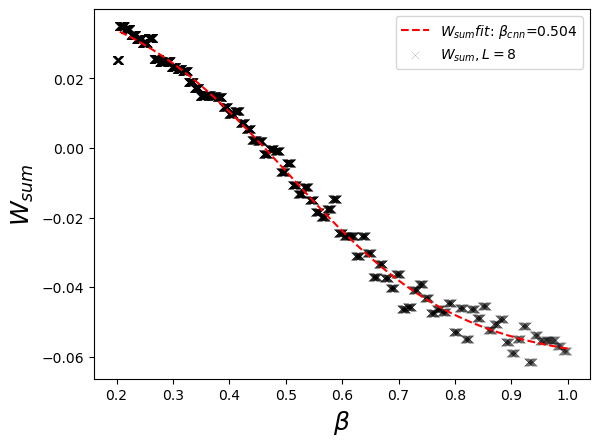

In [ ]:
from scipy import special
W_sum = np.matmul(filters_m, beta_hot.transpose()).sum(axis=0)*10**-2
print(W_sum.shape)
def mag(bet, a, b, c, betacnn):
  return a*np.tanh(c*(bet-betacnn))-b
def erf(beta, a, b, c, betacnn):
  return b + 0.5*a*(1 + special.erf(c*(beta-betacnn)))
def exp(bet, a, b, c, betacnn):
  return b + a*np.exp(c*(bet-betacnn))
popt1, pcov1 = curve_fit(mag, beta[1837:], W_sum)
fig, ax = plt.subplots(1, 1)
ax.plot(beta[1837:], mag(beta[1837:], *popt1), 'r--',
         label=r'$W_{sum}fit$: $\beta_{cnn}$=%5.3f' % popt1[3])
ax.scatter(beta[1837:], W_sum, marker='x', s=30, c='black', linewidths=0.09, label=r'$W_{sum}, L=$%i' % data.shape[1])
ax.set_ylabel(r'$W_{sum}$', fontsize=18)
ax.set_xlabel(r'$\beta$', fontsize=18)
plt.legend()
#plt.ylim([-100, 0.1])
plt.show()

Text(0, 0.5, 'Accuracy')

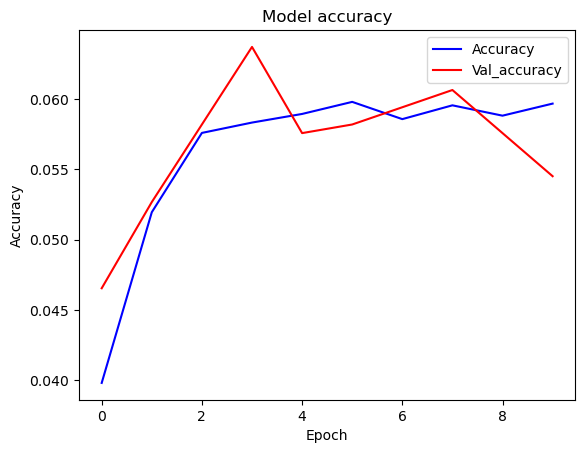

In [ ]:
plt.plot(history.history['accuracy'], c='b', label='Accuracy')
plt.plot(history.history['val_accuracy'], c = 'r', label='Val_accuracy')
plt.title('Model accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

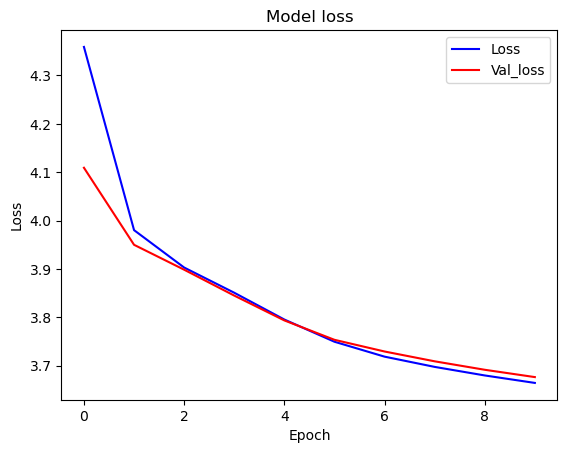

In [ ]:
plt.plot(history.history['loss'], c='b', label='Loss')
plt.plot(history.history['val_loss'], c = 'r', label='Val_loss')
plt.title('Model loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
#import os.path
#if os.path.isfile('ising_model_10000_L8.h5') is False:
#    model.save('ising_model_10000_L8.h5')